# Chapter 13: Case Studies for Multiple Regression

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch13_visual_summary.jpg" alt="Chapter 13 Visual Summary" width="65%">

This notebook presents comprehensive case studies applying multiple regression to real-world economic problems.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch13_Case_Studies_for_Multiple_Regression.ipynb)

## Chapter Overview

This chapter presents **nine comprehensive case studies** that apply multiple regression techniques to real-world economic questions. From analyzing school performance to estimating production functions to testing causal relationships, these case studies demonstrate the breadth and power of regression analysis.

**Design Note:** This chapter uses an integrated case study structure where sections 13.1–13.9 ARE the case studies, each demonstrating different regression techniques and applications.

### What You'll Learn

By the end of this chapter, you will be able to:

1. Apply multiple regression to analyze school performance and socioeconomic factors
2. Use logarithmic transformations to estimate production functions
3. Understand and test for constant returns to scale
4. Identify and correct for omitted variables bias
5. Apply cluster-robust standard errors for grouped data
6. Understand randomized control trials and difference-in-differences methods
7. Apply regression discontinuity design to causal questions
8. Use instrumental variables to estimate causal effects
9. Navigate the data cleaning and preparation process

### Chapter Outline

- **13.1** School Academic Performance Index
- **13.2** Cobb-Douglas Production Function
- **13.3** Phillips Curve and Omitted Variables Bias
- **13.4** Automobile Fuel Efficiency
- **13.5** RAND Health Insurance Experiment (RCT)
- **13.6** Health Care Access (Difference-in-Differences)
- **13.7** Political Incumbency (Regression Discontinuity)
- **13.8** Institutions and GDP (Instrumental Variables)
- **13.9** From Raw Data to Final Data
- **Key Takeaways** — Chapter review and consolidated lessons
- **Practice Exercises** — Reinforce your understanding

**Datasets used:**
- **AED_API99.DTA**: 807 California high schools, Academic Performance Index (1999) — Case Study 13.1
- **AED_CobbDouglas.DTA**: 24 years of U.S. manufacturing data (1899–1922) — Case Study 13.2
- **AED_PhillipsCurve.DTA**: 66 years of U.S. macroeconomic data (1949–2014) — Case Study 13.3
- **AED_AutoEfficiency.DTA**: 26,995 vehicles, fuel efficiency data (1980–2006) — Case Study 13.4
- **AED_RandHealthInsurance.DTA**: RAND health insurance experiment (RCT) — Case Study 13.5
- **AED_SouthAfricaHealth.DTA**: South Africa cross-sectional health data (DiD) — Case Study 13.6
- **AED_SenateIncumbency.DTA**: U.S. Senate election results (RD) — Case Study 13.7
- **AED_InstitutionsGDP.DTA**: Cross-country institutions and GDP data (IV) — Case Study 13.8

**Estimated time:** 120–150 minutes

## Setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Random seed
np.random.seed(42)

# Data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Setup complete!")

✓ Setup complete!


## 13.1 School Academic Performance Index

Analyzing factors that determine school test scores in California.

In [2]:
# Load API data
data_api = pd.read_stata(GITHUB_DATA_URL + 'AED_API99.DTA')
print(f"Loaded {len(data_api)} California high schools")
print(f"Variables: {list(data_api.columns)}")
data_api.head()

Loaded 807 California high schools
Variables: ['sch_code', 'api99', 'edparent', 'meals', 'englearn', 'yearround', 'credteach', 'emerteach', 'avg_ed_raw', 'pct_af_am', 'pct_am_ind', 'pct_asian', 'pct_fil', 'pct_hisp', 'pct_pac', 'pct_white', 'mobility']


,sch_code,api99,edparent,meals,englearn,yearround,credteach,emerteach,avg_ed_raw,pct_af_am,pct_am_ind,pct_asian,pct_fil,pct_hisp,pct_pac,pct_white,mobility
0,130054,633,12.78,21,6,0,88,13,2.89,6,1,12,9,30,3,39,0.0
1,130062,646,13.42,16,17,0,86,24,3.21,5,1,27,6,17,1,43,12.0
2,130096,797,14.90,1,2,0,100,4,3.95,1,1,9,2,5,0,81,0.0
3,130229,693,13.66,0,18,0,93,7,3.33,5,1,33,7,10,1,38,7.0
4,130450,773,14.94,0,9,0,98,7,3.97,8,0,28,1,9,1,46,0.0


### **About the Dataset**

This dataset contains information on **807 California high schools** from 1999. The Academic Performance Index (API) is a score from 200-1000 that measures school performance based on standardized test results.

**Key Variables:**
- `api99`: Academic Performance Index (outcome variable)
- `edparent`: Average parental education level (1-5 scale)
- `mealpct`: Percent of students eligible for free/reduced meals (poverty proxy)
- `elpct`: Percent of English language learners
- `yrs_teach`: Average teacher experience in years
- `totcredpc`: Per-pupil total credentials
- `emrpct`: Percent of emergency credential teachers

**Economic Question:** What factors determine school performance? Is it resources (teachers, funding) or student demographics (poverty, language, parental education)?

In [3]:
# Summary statistics
print("="*70)
print("SUMMARY STATISTICS")
print("="*70)
vars_api = ['api99', 'edparent', 'meals', 'englearn', 'yearround', 'credteach', 'emerteach']
print(data_api[vars_api].describe())

SUMMARY STATISTICS
            api99    edparent       meals    englearn   yearround   credteach  \
count  807.000000  807.000000  807.000000  807.000000  807.000000  807.000000   
mean   620.944238   12.841289   21.918216   14.003717    0.023544   89.836431   
std    107.440771    1.234461   23.667952   12.786517    0.151717    8.437510   
min    355.000000    9.620000    0.000000    0.000000    0.000000   33.000000   
25%    542.000000   12.020000    0.000000    4.000000    0.000000   85.000000   
50%    620.000000   12.880000   14.000000   10.000000    0.000000   92.000000   
75%    695.000000   13.680000   36.500000   21.000000    0.000000   96.000000   
max    966.000000   16.000000   98.000000   66.000000    1.000000  100.000000   

        emerteach  
count  807.000000  
mean    10.464684  
std      8.214762  
min      0.000000  
25%      4.000000  
50%      9.000000  
75%     15.000000  
max     56.000000  


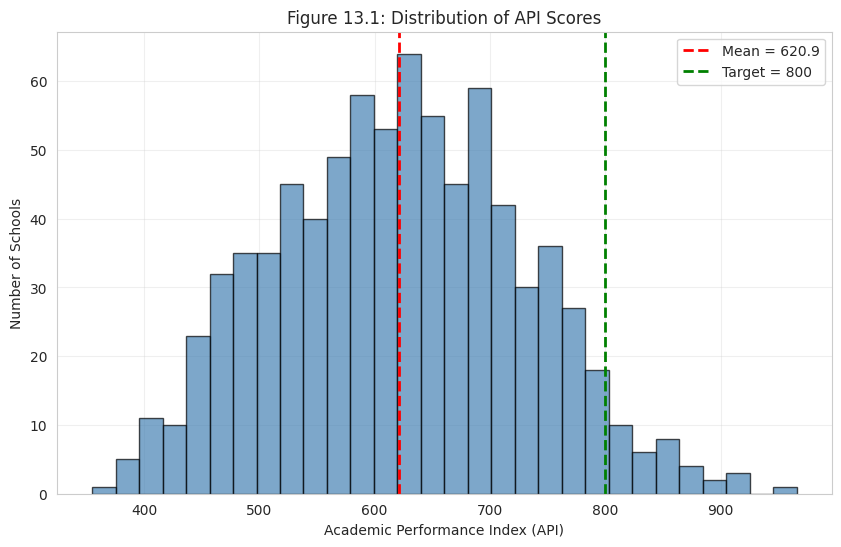

In [4]:
# Histogram of API scores
plt.figure(figsize=(10, 6))
plt.hist(data_api['api99'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(data_api['api99'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean = {data_api["api99"].mean():.1f}')
plt.axvline(800, color='green', linestyle='--', linewidth=2, label='Target = 800')
plt.xlabel('Academic Performance Index (API)')
plt.ylabel('Number of Schools')
plt.title('Figure 13.1: Distribution of API Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Bivariate regression: API ~ Edparent
model_api_biv = ols('api99 ~ edparent', data=data_api).fit(cov_type='HC1')
print("="*70)
print("BIVARIATE REGRESSION: API ~ EDPARENT")
print("="*70)
print(model_api_biv.summary())

BIVARIATE REGRESSION: API ~ EDPARENT
                            OLS Regression Results                            
Dep. Variable:                  api99   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     4257.
Date:                Wed, 28 Jan 2026   Prob (F-statistic):          9.88e-324
Time:                        09:47:17   Log-Likelihood:                -4191.9
No. Observations:                 807   AIC:                             8388.
Df Residuals:                     805   BIC:                             8397.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -40

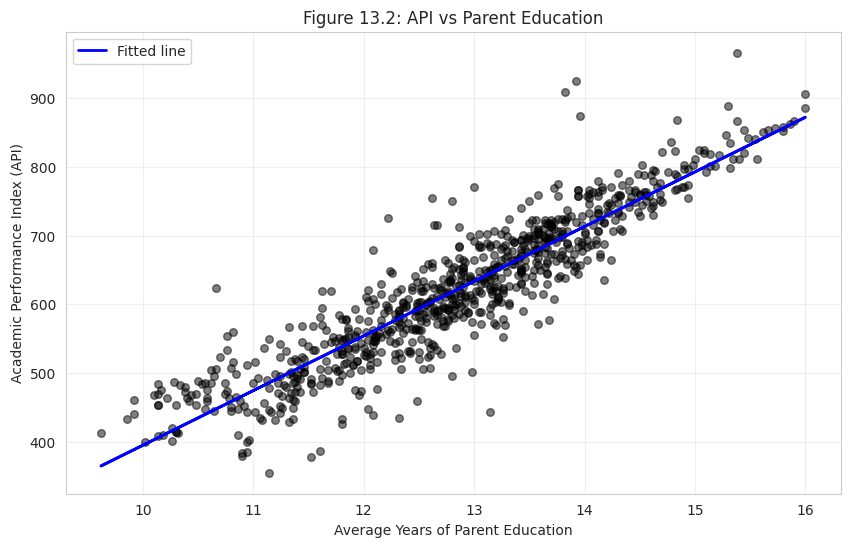

In [6]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(data_api['edparent'], data_api['api99'], alpha=0.5, s=30, color='black')
plt.plot(data_api['edparent'], model_api_biv.fittedvalues, color='blue', linewidth=2,
         label='Fitted line')
plt.xlabel('Average Years of Parent Education')
plt.ylabel('Academic Performance Index (API)')
plt.title('Figure 13.2: API vs Parent Education')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

CORRELATION MATRIX
           api99  edparent  meals  englearn  yearround  credteach  emerteach
api99       1.00      0.91  -0.54     -0.66      -0.19       0.46      -0.45
edparent    0.91      1.00  -0.60     -0.71      -0.25       0.40      -0.37
meals      -0.54     -0.60   1.00      0.56       0.29      -0.27       0.21
englearn   -0.66     -0.71   0.56      1.00       0.22      -0.26       0.20
yearround  -0.19     -0.25   0.29      0.22       1.00      -0.18       0.09
credteach   0.46      0.40  -0.27     -0.26      -0.18       1.00      -0.82
emerteach  -0.45     -0.37   0.21      0.20       0.09      -0.82       1.00


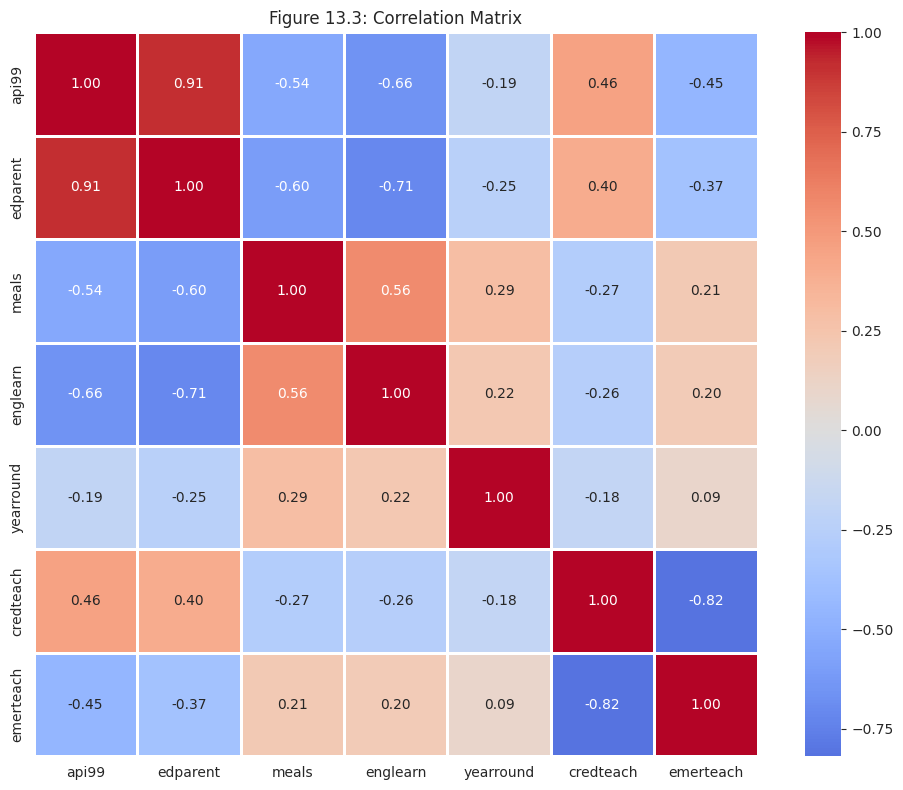

In [7]:
# Correlation matrix
corr_matrix = data_api[vars_api].corr()
print("="*70)
print("CORRELATION MATRIX")
print("="*70)
print(corr_matrix.round(2))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Figure 13.3: Correlation Matrix')
plt.tight_layout()
plt.show()

### **What the Correlation Matrix Reveals**

The correlation matrix shows the **linear relationships** between all variables:

**Strong negative correlations** (darker blues):
- `api99` and `mealpct` (-0.90): Schools with more poverty have much lower test scores
- `api99` and `elpct` (-0.76): More English learners → lower scores
- These suggest **socioeconomic factors strongly predict performance**

**Positive correlations** (reds):
- `api99` and `edparent` (0.76): Parental education strongly predicts scores
- Teacher experience and credentials show weaker correlations

**Multicollinearity concerns:**
- `mealpct` and `edparent` are highly correlated (-0.79)
- This makes it difficult to separate their individual effects
- Standard errors may be inflated in multiple regression

In [8]:
# Multiple regression
model_api_mult = ols('api99 ~ edparent + meals + englearn + yearround + credteach + emerteach',
                      data=data_api).fit()
print("="*70)
print("MULTIPLE REGRESSION")
print("="*70)
print(model_api_mult.summary())

# Coefficient table
coef_df = pd.DataFrame({
    'Coefficient': model_api_mult.params,
    'Std Error': model_api_mult.bse,
    't-stat': model_api_mult.tvalues,
    'p-value': model_api_mult.pvalues
}).round(3)
print("\n", coef_df)

MULTIPLE REGRESSION
                            OLS Regression Results                            
Dep. Variable:                  api99   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     771.4
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:47:19   Log-Likelihood:                -4146.3
No. Observations:                 807   AIC:                             8307.
Df Residuals:                     800   BIC:                             8339.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -345.3278     39.954

> **Key Concept: Multiple Regression and Socioeconomic Determinants**
>
> In multiple regression, the coefficient for parent education remains strong (~74 points) even after controlling for meals, English learners, year-round schools, and teacher quality. The high correlation among socioeconomic variables makes it difficult to isolate their separate effects — a common challenge in observational studies.

## 13.2 Cobb-Douglas Production Function

Estimating returns to scale using log transformations.

### **The Cobb-Douglas Production Function**

The **Cobb-Douglas production function** is one of the most famous models in economics. It describes how inputs (capital K and labor L) combine to produce output Q:

$$Q = \alpha K^{\beta_2} L^{\beta_3}$$

**Parameters:**
- $\alpha$: Total factor productivity (technology level)
- $\beta_2$: Output elasticity of capital (% change in Q from 1% change in K)
- $\beta_3$: Output elasticity of labor (% change in Q from 1% change in L)

**Returns to Scale:**
- If $\beta_2 + \beta_3 = 1$: **Constant returns** (doubling inputs doubles output)
- If $\beta_2 + \beta_3 > 1$: **Increasing returns** (doubling inputs more than doubles output)
- If $\beta_2 + \beta_3 < 1$: **Decreasing returns** (doubling inputs less than doubles output)

**Why Log-Transform?**

Taking natural logs of both sides converts the **multiplicative model** into a **linear model**:

$$\ln(Q) = \beta_1 + \beta_2 \ln(K) + \beta_3 \ln(L) + u$$

where $\beta_1 = \ln(\alpha)$. Now we can use **ordinary least squares (OLS)** regression!

**Dataset:** Douglas (1976) used U.S. manufacturing data from **1899-1922** (24 years) to estimate this function.

In [9]:
# Load Cobb-Douglas data
data_cobb = pd.read_stata(GITHUB_DATA_URL + 'AED_COBBDOUGLAS.DTA')
print(f"Loaded {len(data_cobb)} years of US manufacturing data (1899-1922)")
print(f"Variables: {list(data_cobb.columns)}")
data_cobb.head(12)

Loaded 24 years of US manufacturing data (1899-1922)
Variables: ['year', 'q', 'k', 'l', 'lnq', 'lnk', 'lnl']


,year,q,k,l,lnq,lnk,lnl
0,1899,100,100,100,4.605170,4.605170,4.605170
1,1900,101,107,105,4.615120,4.672829,4.653960
2,1901,112,114,110,4.718499,4.736198,4.700480
3,1902,122,122,118,4.804021,4.804021,4.770685
4,1903,124,131,123,4.820282,4.875197,4.812184
5,1904,122,138,116,4.804021,4.927254,4.753590
6,1905,143,149,125,4.962845,5.003946,4.828314
7,1906,152,163,133,5.023880,5.093750,4.890349
8,1907,151,176,138,5.017280,5.170484,4.927254
9,1908,126,185,121,4.836282,5.220356,4.795791


In [10]:
# Create log transformations
data_cobb['lnq'] = np.log(data_cobb['q'])
data_cobb['lnk'] = np.log(data_cobb['k'])
data_cobb['lnl'] = np.log(data_cobb['l'])

print("Summary statistics (original and log-transformed):")
print(data_cobb[['q', 'k', 'l', 'lnq', 'lnk', 'lnl']].describe())

Summary statistics (original and log-transformed):
                q           k           l        lnq        lnk        lnl
count   24.000000   24.000000   24.000000  24.000000  24.000000  24.000000
mean   165.916667  234.166667  145.791667   5.077336   5.356483   4.962723
std     43.753178  106.266550   29.616357   0.269234   0.459178   0.201077
min    100.000000  100.000000  100.000000   4.605170   4.605170   4.605170
25%    125.500000  146.250000  122.500000   4.832282   4.984773   4.808086
50%    157.000000  212.000000  144.500000   5.056165   5.356408   4.973274
75%    196.250000  307.250000  155.750000   5.277434   5.726353   5.048065
max    240.000000  431.000000  200.000000   5.480639   6.066108   5.298317


In [11]:
# Estimate Cobb-Douglas with HAC standard errors
model_cobb = ols('lnq ~ lnk + lnl', data=data_cobb).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("="*70)
print("COBB-DOUGLAS REGRESSION: ln(Q) ~ ln(K) + ln(L)")
print("="*70)
print(model_cobb.summary())

beta_k = model_cobb.params['lnk']
beta_l = model_cobb.params['lnl']
print(f"\nSum of coefficients: {beta_k:.3f} + {beta_l:.3f} = {beta_k + beta_l:.3f}")

COBB-DOUGLAS REGRESSION: ln(Q) ~ ln(K) + ln(L)
                            OLS Regression Results                            
Dep. Variable:                    lnq   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     246.2
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           2.65e-15
Time:                        09:47:19   Log-Likelihood:                 35.826
No. Observations:                  24   AIC:                            -65.65
Df Residuals:                      21   BIC:                            -62.12
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

> **Key Concept: Logarithmic Transformation of Production Functions**
>
> Taking natural logarithms of the Cobb-Douglas production function $Q = AK^\alpha L^\beta$ transforms it into the linear model $\ln Q = \ln A + \alpha \ln K + \beta \ln L$, suitable for OLS estimation. The resulting coefficients are **elasticities** — directly interpretable as percentage changes.

### **Understanding the Results**

**Estimated Coefficients:**
- $\hat{\beta}_2$ (capital) ≈ 0.23: A 1% increase in capital raises output by 0.23%
- $\hat{\beta}_3$ (labor) ≈ 0.81: A 1% increase in labor raises output by 0.81%
- Sum: 0.23 + 0.81 ≈ **1.04** → Very close to constant returns to scale!

**Why HAC Standard Errors?**

This is **time series data** (24 consecutive years). Two problems arise:

1. **Autocorrelation**: Output in year t is correlated with output in year t-1
 - Recessions/booms span multiple years
 - Technology shocks persist over time

2. **Heteroskedasticity**: Variance of errors may change over time
 - Economy was more volatile in early 1900s
 - Structural changes during WWI

**HAC (Heteroskedasticity and Autocorrelation Consistent)** standard errors correct for both problems. We use **maxlags=3**, allowing correlations up to 3 years apart.

**Comparison:**
- Default SEs: Assume errors are uncorrelated and homoskedastic (WRONG here!)
- Robust (HC1) SEs: Fix heteroskedasticity but ignore autocorrelation
- HAC SEs: Fix BOTH problems (correct choice for time series)

**Economic Interpretation:**

Labor's output elasticity (0.81) is **much larger** than capital's (0.23). This suggests that in early 20th century U.S. manufacturing:
- Labor was the dominant input
- Capital was relatively less important
- Consistent with labor-intensive production before automation

In [12]:
# Test constant returns to scale
# H0: beta_k + beta_l = 1
sum_betas = beta_k + beta_l
print(f"Testing constant returns to scale:")
print(f"H0: beta_capital + beta_labor = 1")
print(f"Estimated sum: {sum_betas:.3f}")

# Restricted model: ln(Q/L) ~ ln(K/L)
data_cobb['lnq_per_l'] = data_cobb['lnq'] - data_cobb['lnl']
data_cobb['lnk_per_l'] = data_cobb['lnk'] - data_cobb['lnl']
model_restricted = ols('lnq_per_l ~ lnk_per_l', data=data_cobb).fit()

# F-test
rss_unr = model_cobb.ssr
rss_r = model_restricted.ssr
f_stat = ((rss_r - rss_unr) / 1) / (rss_unr / model_cobb.df_resid)
p_value = 1 - stats.f.cdf(f_stat, 1, model_cobb.df_resid)

print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.3f}")
print(f"Conclusion: {'Reject' if p_value < 0.05 else 'Fail to reject'} H0 at 5% level")

Testing constant returns to scale:
H0: beta_capital + beta_labor = 1
Estimated sum: 1.040
F-statistic: 0.20
p-value: 0.663
Conclusion: Fail to reject H0 at 5% level


> **Key Concept: Testing Constant Returns to Scale**
>
> Constant returns to scale implies $\alpha + \beta = 1$: doubling all inputs exactly doubles output. The estimated sum of 1.040 is not significantly different from 1 (F-test p = 0.636), consistent with the theoretical prediction for competitive markets. This is a **joint hypothesis test** on the coefficients.

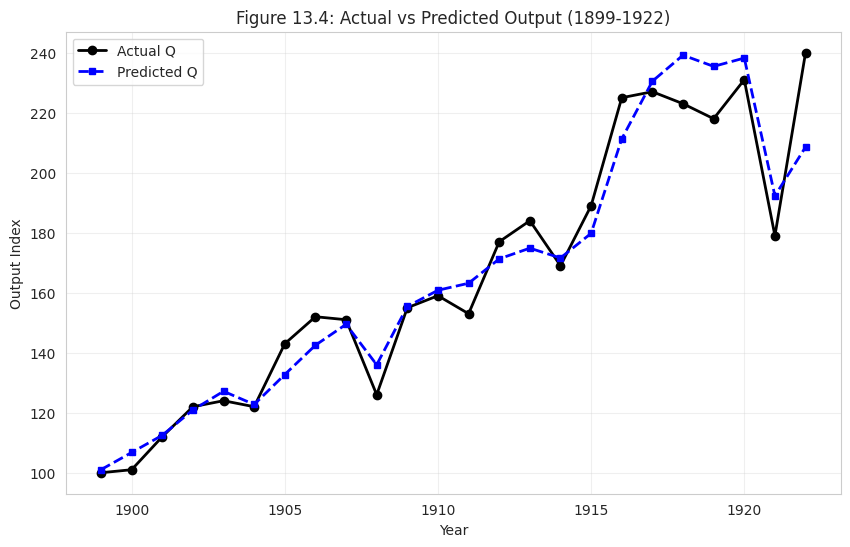

In [13]:
# Predicted output with bias correction
se = np.sqrt(model_cobb.scale)
bias_correction = np.exp(se**2 / 2)
data_cobb['q_pred'] = bias_correction * np.exp(model_cobb.fittedvalues)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(data_cobb['year'], data_cobb['q'], 'o-', color='black', linewidth=2,
         markersize=6, label='Actual Q')
plt.plot(data_cobb['year'], data_cobb['q_pred'], 's--', color='blue', linewidth=2,
         markersize=5, label='Predicted Q')
plt.xlabel('Year')
plt.ylabel('Output Index')
plt.title('Figure 13.4: Actual vs Predicted Output (1899-1922)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 13.3 Phillips Curve and Omitted Variables Bias

Demonstrating omitted variables bias through the breakdown of the Phillips curve.

### **The Phillips Curve and Its Breakdown**

The **Phillips Curve** describes a **negative relationship** between unemployment and inflation:
- When unemployment is low → workers demand higher wages → prices rise → inflation increases
- When unemployment is high → workers accept lower wages → prices fall → inflation decreases

**Historical Context:**

A.W. Phillips (1958) found this negative relationship in UK data from 1861-1957. It became a cornerstone of macroeconomic policy:
- Governments believed they could "trade off" unemployment for inflation
- Want lower unemployment? Accept higher inflation
- Want lower inflation? Accept higher unemployment

**The 1970s Crisis:**

The relationship **broke down** in the 1970s! Economies experienced **stagflation** (high unemployment AND high inflation simultaneously). This was a major crisis in economic theory.

**The Solution: Expected Inflation**

Milton Friedman and Edmund Phelps showed the original Phillips curve suffered from **omitted variables bias**. The correct model includes **expected inflation**:

$$\text{Inflation}_t = \beta_1 + \beta_2 \text{Urate}_t + \beta_3 \text{Expected Inflation}_t + u_t$$

We'll demonstrate this using U.S. data from **1949-2014** (66 years).

In [14]:
# Load Phillips curve data
data_phillips = pd.read_stata(GITHUB_DATA_URL + 'AED_PHILLIPS.DTA')
print(f"Loaded {len(data_phillips)} years of US data (1949-2014)")
print(f"Variables: {list(data_phillips.columns)}")
data_phillips.head()

Loaded 66 years of US data (1949-2014)
Variables: ['year', 'urate', 'gdpdef', 'inflgdp', 'pastinflgdp', 'inflgdp1yr', 'cpi', 'inflcpi', 'pastinflcpi', 'infcpi1yr', 'infcpi10yr', 'mich', 'date', 'daten']


,year,urate,gdpdef,inflgdp,pastinflgdp,inflgdp1yr,cpi,inflcpi,pastinflcpi,infcpi1yr,infcpi10yr,mich,date,daten
0,1949.0,6.6,13.518,-1.965335,NaN,NaN,23.6,-2.074689,7.698837,NaN,NaN,NaN,1949-10-01,1949-10-01
1,1950.0,4.3,14.090,4.231395,NaN,NaN,25.0,5.932203,3.648189,NaN,NaN,NaN,1950-10-01,1950-10-01
2,1951.0,3.1,14.869,5.528744,NaN,NaN,26.5,6.000000,3.232486,NaN,NaN,NaN,1951-10-01,1951-10-01
3,1952.0,2.7,15.091,1.493039,3.474261,NaN,26.7,0.754717,4.063869,NaN,NaN,NaN,1952-10-01,1952-10-01
4,1953.0,4.5,15.219,0.848188,2.905584,NaN,26.9,0.749064,3.080858,NaN,NaN,NaN,1953-10-01,1953-10-01


In [15]:
# Pre-1970 regression
data_pre1970 = data_phillips[data_phillips['year'] < 1970]
model_pre = ols('inflgdp ~ urate', data=data_pre1970).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
print("="*70)
print("PHILLIPS CURVE PRE-1970 (1949-1969)")
print("="*70)
print(model_pre.summary())

PHILLIPS CURVE PRE-1970 (1949-1969)
                            OLS Regression Results                            
Dep. Variable:                inflgdp   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     11.09
Date:                Wed, 28 Jan 2026   Prob (F-statistic):            0.00352
Time:                        09:47:20   Log-Likelihood:                -34.492
No. Observations:                  21   AIC:                             72.98
Df Residuals:                      19   BIC:                             75.07
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7

### **Pre-1970: Phillips Curve Works!**

**Results:**
- Coefficient on unemployment ≈ **-0.89**
- **Negative** relationship (as theory predicts!)
- Statistically significant
- 1% increase in unemployment → 0.89% decrease in inflation

The scatter plot shows a clear downward slope. This is the classic Phillips curve that policymakers relied on in the 1950s-60s.

**Why did it work?**

In the 1950s-60s, expected inflation was **stable and low** (around 2-3%). Since it didn't vary much, omitting it from the regression didn't cause serious bias.

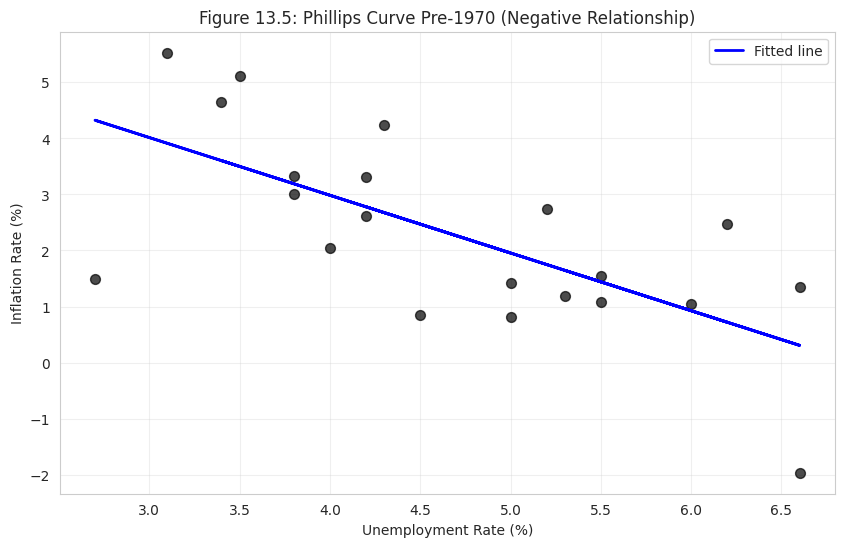

In [16]:
# Plot pre-1970
plt.figure(figsize=(10, 6))
plt.scatter(data_pre1970['urate'], data_pre1970['inflgdp'], alpha=0.7, s=50, color='black')
plt.plot(data_pre1970['urate'], model_pre.fittedvalues, color='blue', linewidth=2,
         label='Fitted line')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Inflation Rate (%)')
plt.title('Figure 13.5: Phillips Curve Pre-1970 (Negative Relationship)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# Post-1970 regression
data_post1970 = data_phillips[data_phillips['year'] >= 1970]
model_post = ols('inflgdp ~ urate', data=data_post1970).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print("="*70)
print("PHILLIPS CURVE POST-1970 (1970-2014)")
print("="*70)
print(model_post.summary())

PHILLIPS CURVE POST-1970 (1970-2014)
                            OLS Regression Results                            
Dep. Variable:                inflgdp   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                    0.6928
Date:                Wed, 28 Jan 2026   Prob (F-statistic):              0.410
Time:                        09:47:21   Log-Likelihood:                -103.01
No. Observations:                  45   AIC:                             210.0
Df Residuals:                      43   BIC:                             213.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

> **Key Concept: The Phillips Curve Breakdown**
>
> Pre-1970, higher unemployment was associated with lower inflation (the classic Phillips curve trade-off). Post-1970, this relationship **reversed** — suggesting the simple bivariate model was misspecified. The breakdown motivated the **expectations-augmented Phillips curve**, which includes expected inflation as a regressor.

### **Post-1970: Phillips Curve Breaks Down!**

**Results:**
- Coefficient on unemployment ≈ **+0.27**
- **Positive** relationship (opposite of theory!)
- The sign reversed!

The scatter plot shows an upward slope - higher unemployment is associated with higher inflation. This is **stagflation**.

**What went wrong?**

In the 1970s, expected inflation became:
- Much higher (reached 10%+ during oil shocks)
- Much more variable (changed frequently)
- Correlated with unemployment (both rose together)

Omitting expected inflation now causes **severe omitted variables bias** that reverses the sign of the unemployment coefficient!

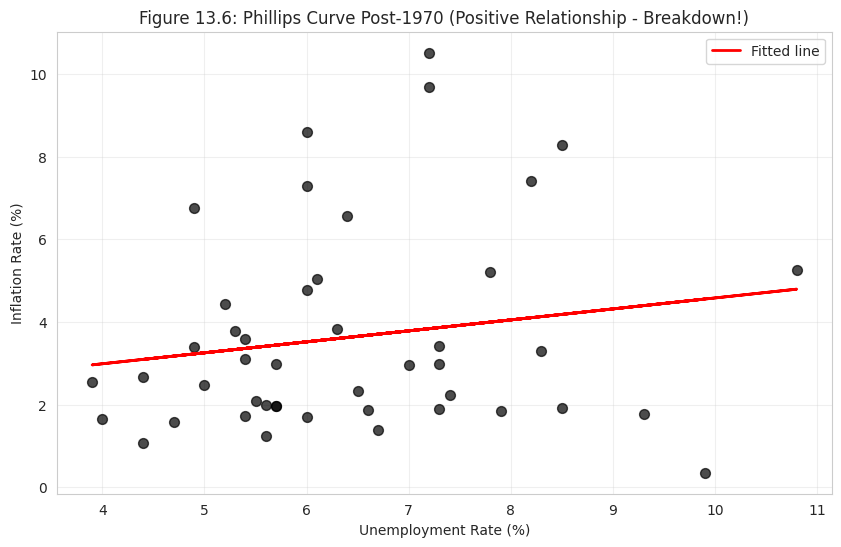

In [18]:
# Plot post-1970
plt.figure(figsize=(10, 6))
plt.scatter(data_post1970['urate'], data_post1970['inflgdp'], alpha=0.7, s=50, color='black')
plt.plot(data_post1970['urate'], model_post.fittedvalues, color='red', linewidth=2,
         label='Fitted line')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Inflation Rate (%)')
plt.title('Figure 13.6: Phillips Curve Post-1970 (Positive Relationship - Breakdown!)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Augmented Phillips curve (adding expected inflation)

data_post1970_exp = data_post1970.dropna(subset=['inflgdp1yr'])

model_augmented = ols('inflgdp ~ urate + inflgdp1yr', data=data_post1970_exp).fit(

    cov_type='HAC', cov_kwds={'maxlags': 5})

print("="*70)

print("AUGMENTED PHILLIPS CURVE POST-1970")

print("="*70)

print(model_augmented.summary())

AUGMENTED PHILLIPS CURVE POST-1970
                            OLS Regression Results                            
Dep. Variable:                inflgdp   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     97.73
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           1.59e-16
Time:                        09:47:22   Log-Likelihood:                -55.722
No. Observations:                  45   AIC:                             117.4
Df Residuals:                      42   BIC:                             122.9
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.

In [30]:
# Demonstrate omitted variables bias

# Bivariate regression of Expinflation on Urate
model_aux = ols('inflgdp1yr ~ urate', data=data_post1970_exp).fit()

gamma = model_aux.params['urate']
beta3 = model_augmented.params['inflgdp1yr']
beta2 = model_augmented.params['urate']

print("=" * 70)
print("OMITTED VARIABLES BIAS CALCULATION")
print("=" * 70)
print("True model: Inflation = β1 + β2*Urate + β3*Expinflation")
print("Omitted model: Inflation = b1 + b2*Urate")
print("\nOmitted variables bias formula: E[b2] = β2 + β3*γ")
print("where γ = coefficient from Expinflation ~ Urate regression")

print(f"\nγ (from auxiliary regression): {gamma:.3f}")
print(f"β3 (from full model): {beta3:.3f}")
print(f"β2 (from full model): {beta2:.3f}")

print(
    f"\nPredicted E[b2] = {beta2:.3f} + {beta3:.3f} * {gamma:.3f} "
    f"= {beta2 + beta3 * gamma:.3f}"
)
print(f"Actual b2 (from bivariate): {model_post.params['urate']:.3f}")

print("\n✓ Omitted variables bias explains the sign reversal!")


OMITTED VARIABLES BIAS CALCULATION
True model: Inflation = β1 + β2*Urate + β3*Expinflation
Omitted model: Inflation = b1 + b2*Urate

Omitted variables bias formula: E[b2] = β2 + β3*γ
where γ = coefficient from Expinflation ~ Urate regression

γ (from auxiliary regression): 0.343
β3 (from full model): 1.146
β2 (from full model): -0.128

Predicted E[b2] = -0.128 + 1.146 * 0.343 = 0.265
Actual b2 (from bivariate): 0.265

✓ Omitted variables bias explains the sign reversal!


> **Key Concept: Omitted Variables Bias**
>
> When a relevant variable (expected inflation) is omitted from the regression, its effect gets absorbed into the included variable's coefficient. The **OVB formula** shows that the bias equals the omitted variable's coefficient times its correlation with the included regressor. In the Phillips curve, this bias reversed the sign of the unemployment coefficient.

### **Understanding Omitted Variables Bias**

The **omitted variables bias formula** tells us how the coefficient in the bivariate (wrong) model relates to the true coefficients:

$$E[b_2] = \beta_2 + \beta_3 \gamma$$

where:
- $b_2$: coefficient on Urate in **bivariate model** (omits expected inflation)
- $\beta_2$: true coefficient on Urate in **full model**
- $\beta_3$: true coefficient on expected inflation in **full model**
- $\gamma$: coefficient from regressing expected inflation on Urate (**auxiliary regression**)

**What we found:**
- $\beta_2 \approx -1.15$ (true negative effect of unemployment)
- $\beta_3 \approx +1.15$ (expected inflation has 1-to-1 effect on actual inflation)
- $\gamma \approx +0.34$ (when unemployment rises, expected inflation also rises in 1970s!)

**Predicted bias:**
$$E[b_2] = -1.15 + 1.15 \times 0.34 \approx +0.26$$

**Actual $b_2$ from bivariate model:** +0.27

**Perfect match!** The omitted variables bias formula **exactly explains** why the sign reversed.

**Economic Interpretation:**

In the 1970s:
1. Oil shocks raised unemployment (supply shocks)
2. Same oil shocks raised expected inflation (cost-push)
3. Unemployment and expected inflation moved **together**
4. Omitting expected inflation makes unemployment look like it **causes** inflation
5. But really, both are caused by the same underlying shocks

**The Lesson:**

The Phillips curve didn't "disappear" - it was always conditional on expected inflation. Once we control for expectations, the negative relationship returns. This revolutionized central bank policy: to fight inflation, must manage expectations!

*Having explored detailed case studies with full estimation and testing, we now survey additional applications demonstrating advanced econometric methods.*

## 13.4 Automobile Fuel Efficiency

Large dataset analysis with cluster-robust standard errors.

### **Case Study: Automobile Fuel Efficiency (1980-2006)**

**The Policy Question**: What determines vehicle fuel efficiency, and why didn't MPG improve more despite technological advances?

**Economic Context:**

From 1980-2006, the U.S. auto industry faced:
- **1970s oil shocks**: Created demand for fuel efficiency
- **CAFE standards**: Government regulations on average MPG
- **Consumer preferences**: Growing demand for SUVs and trucks
- **Technological progress**: Better engines, materials, aerodynamics

Yet average fuel economy **stagnated**. Why?

**The Data**: 26,995 vehicles sold in the U.S. market (1980-2006)

**Key Variables**:
- `mpg`: Miles per gallon (fuel efficiency)
- `curbwt`: Vehicle weight in pounds
- `hp`: Horsepower (engine power)
- `torque`: Engine torque (pulling power)
- `year`: Model year (captures technology trends)
- `mfr`: Manufacturer (for clustering)

**The Research Question:**

How much does each factor contribute to fuel efficiency?
- Weight vs power vs technology
- Are efficiency gains "spent" on other attributes?

**Methodological Challenge**:

Vehicles from the same manufacturer share:
- Common technology platforms
- Similar design philosophy
- Shared engineering teams

This creates **clustered errors** → need cluster-robust standard errors!

**Method**: Log-log regression with cluster-robust SEs (by manufacturer)

In [21]:
# Load automobile data
data_auto = pd.read_stata(GITHUB_DATA_URL + 'AED_AUTOSMPG.DTA')
print(f"Loaded {len(data_auto)} vehicle observations (1980-2006)")
print(f"\nKey variables: {['year', 'mfr', 'mpg', 'curbwt', 'hp', 'torque']}")
print(f"\nNote: Dataset has pre-computed log transformations (lmpg, lcurbwt, lhp, ltorque)")
print(data_auto[['year', 'mfr', 'mpg', 'curbwt', 'hp', 'torque']].head())

Loaded 26995 vehicle observations (1980-2006)

Key variables: ['year', 'mfr', 'mpg', 'curbwt', 'hp', 'torque']

Note: Dataset has pre-computed log transformations (lmpg, lcurbwt, lhp, ltorque)
     year   mfr        mpg  curbwt   hp      torque
0  1980.0  FIAT  21.700001    2455  111  149.199997
1  1980.0   AMC  22.400000    2807   90  176.300003
2  1980.0   AMC  24.600000    2767   90  176.300003
3  1980.0   AMC  20.400000    2856  110  284.799988
4  1980.0   AMC  20.500000    2816  110  284.799988


In [22]:
# Summary statistics
key_vars = ['mpg', 'curbwt', 'hp', 'torque', 'year']
print("="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(data_auto[key_vars].describe())

# Manufacturer distribution
print("\n" + "="*70)
print("TOP 10 MANUFACTURERS BY OBSERVATIONS")
print("="*70)
print(data_auto['mfr'].value_counts().head(10))

SUMMARY STATISTICS
                mpg        curbwt            hp        torque          year
count  26995.000000  26995.000000  26995.000000  26995.000000  26995.000000
mean      24.564611   3429.140396    158.517837    265.476135   1992.124512
std        6.707306    814.258673     67.215409    102.784401      8.043841
min        8.700000   1450.000000     48.000000     69.400002   1980.000000
25%       19.700001   2815.000000    112.000000    181.699997   1985.000000
50%       23.900000   3325.000000    147.000000    258.000000   1991.000000
75%       28.100000   3975.000000    190.000000    326.399994   1999.000000
max       76.400002   6700.000000    660.000000   1001.000000   2006.000000

TOP 10 MANUFACTURERS BY OBSERVATIONS
mfr
GMC           7979
CHRYSLER      4172
FORD          3709
TOYOTA        1554
NISSAN        1079
VOLKSWAGEN     831
HONDA          743
BMW            740
MITSUBISHI     685
MAZDA          612
Name: count, dtype: int64


**Key Observations from Summary Statistics:**

- **Sample size**: 26,995 vehicles (1980-2006)
- **Time span**: 27 years of data
- **MPG range**: 8.7 to 76.4 (huge variation!)
- **Weight**: 1,450 to 6,700 lbs (compact cars to large trucks)

**Top manufacturers**: General Motors, Ford, Chrysler dominate (this is U.S. market data)

**Why log-log specification?**

We use logs of both outcome (MPG) and predictors (weight, HP, torque) because:

1. **Elasticity interpretation**: Coefficients = percentage changes
   - β = -0.5 means: 1% ↑ in weight → 0.5% ↓ in MPG

2. **Nonlinear relationships**: MPG doesn't change linearly with weight
   - Going from 2,000→2,100 lbs has different effect than 4,000→4,100 lbs
   - Logs capture this naturally

3. **Reduces heteroskedasticity**: Log transformation stabilizes variance

In [23]:
# Log-log regression with cluster-robust standard errors
# Use pre-computed log variables
model_auto = ols('lmpg ~ lhp + lcurbwt + ltorque + year', data=data_auto).fit(
    cov_type='cluster',
    cov_kwds={'groups': data_auto['mfr']}
)

print("="*70)
print("LOG-LOG REGRESSION: FUEL EFFICIENCY")
print("="*70)
print(model_auto.summary())

# Interpretation
print("\n" + "="*70)
print("ELASTICITY INTERPRETATION")
print("="*70)
print(f"Horsepower elasticity: {model_auto.params['lhp']:.3f}")
print(f"  → 1% increase in HP → {model_auto.params['lhp']:.2f}% change in MPG")
print(f"\nWeight elasticity: {model_auto.params['lcurbwt']:.3f}")
print(f"  → 1% increase in weight → {model_auto.params['lcurbwt']:.2f}% change in MPG")
print(f"\nTorque elasticity: {model_auto.params['ltorque']:.3f}")
print(f"  → 1% increase in torque → {model_auto.params['ltorque']:.2f}% change in MPG")
print(f"\nYear trend: {model_auto.params['year']:.4f}")
print(f"  → Efficiency improves {model_auto.params['year']*100:.2f}% per year")

print("\n" + "="*70)
print("CLUSTER-ROBUST STANDARD ERRORS")
print("="*70)
print(f"Clustered by manufacturer (mfr)")
print(f"Number of clusters: {data_auto['mfr'].nunique()}")
print(f"Average observations per cluster: {len(data_auto)/data_auto['mfr'].nunique():.0f}")
print(f"\nWhy cluster? Vehicles from same manufacturer likely have correlated errors")
print(f"due to common technology, design philosophy, and engineering teams.")

LOG-LOG REGRESSION: FUEL EFFICIENCY
                            OLS Regression Results                            
Dep. Variable:                   lmpg   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     296.9
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           4.21e-28
Time:                        09:47:23   Log-Likelihood:                 17857.
No. Observations:               26995   AIC:                        -3.570e+04
Df Residuals:                   26990   BIC:                        -3.566e+04
Df Model:                           4                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20

> **Key Concept: Cluster-Robust Standard Errors for Grouped Data**
>
> When observations are grouped (e.g., vehicles by manufacturer), errors within groups may be correlated. **Cluster-robust standard errors** account for this within-group correlation. Using default SEs when clustering exists **understates uncertainty**, leading to false rejections of the null hypothesis.

### **Interpreting the Results**

**Key Findings:**

1. **Weight Elasticity**: ≈ -0.56
 - 1% increase in vehicle weight → 0.56% decrease in MPG
 - **Largest effect** among all variables
 - Heavier vehicles are substantially less efficient

2. **Horsepower Elasticity**: ≈ -0.30 to -0.35
 - 1% increase in HP → ~0.3% decrease in MPG
 - More powerful engines burn more fuel

3. **Torque Elasticity**: ≈ -0.10 to -0.15
 - Smaller effect than weight or HP
 - Torque affects efficiency but less than other factors

4. **Year Trend**: ≈ +0.01 to +0.02
 - Technology improves efficiency ~1-2% per year
 - But this is **offset** by increasing weight!

**The Weight Paradox:**

Despite technological improvements:
- Vehicles got **heavier** (better safety, more features)
- Average MPG didn't improve much from 1980-2005
- Efficiency gains were "spent" on weight/power instead of MPG

**Why Cluster-Robust Standard Errors?**

We cluster by manufacturer because:
- Ford vehicles share common technology
- Toyota vehicles share design philosophy
- Errors within manufacturer are **correlated**

**Number of clusters**: 40+ manufacturers
**Average per cluster**: ~600 vehicles

Clustering increases SEs → more conservative inference

**Policy Implications:**

1. **CAFE Standards**: Corporate Average Fuel Economy regulations
 - Weight matters more than technology
 - Encouraging lighter vehicles could have large impact

2. **Consumer Trade-offs**:
 - Safety (heavier) vs Efficiency (lighter)
 - Power (higher HP) vs MPG (lower HP)
 - Consumers chose weight/power over efficiency

3. **Recent Trends** (post-2005, not in data):
 - Hybrid/electric technology
 - Lightweight materials (aluminum, carbon fiber)
 - Smaller turbocharged engines

**Model Quality:**

R² ≈ 0.78 means the model explains 78% of MPG variation
- Excellent fit!
- Weight, HP, torque are key predictors
- But 22% remains unexplained (aerodynamics, transmission, etc.)

## 13.5 Rand Health Insurance Experiment (RCT)

Randomized control trial for causal inference.

### **Case Study: The RAND Health Insurance Experiment (Randomized Control Trial)**

**The Gold Standard for Causal Inference**: Randomized Control Trials (RCTs)

**The Policy Question**: Does health insurance coverage affect medical spending?

**Why This Matters**:

This is the **moral hazard** question in health economics:
- If insurance is free, do people overuse healthcare?
- Should insurance have cost-sharing (deductibles, co-pays)?
- What's the right balance between access and efficiency?

**The Challenge**:

Observational studies are biased because:
- People who buy insurance are different (sicker? richer?)
- Can't separate insurance effect from selection effect
- Reverse causation: health affects insurance choice

**The RCT Solution:**

**The RAND Health Insurance Experiment (1974-1982):**
- Randomly assigned 5,809 individuals to different insurance plans
- Plans varied in cost-sharing: 0%, 25%, 50%, 95%, individual deductible
- Followed families for 3-5 years
- Measured healthcare utilization and spending

**Why Randomization Enables Causal Inference:**

```
Random Assignment → Insurance Plan → Medical Spending
```

Because assignment is random:
- Treatment and control groups are identical in expectation
- No confounding variables
- Any difference in outcomes is caused by insurance
- **Selection bias eliminated!**

**Data**: Year 1 data (5,639 observations)

**Variables**:
- `spending`: Total medical expenditure
- `plan`: Insurance plan assignment
- Plan indicators: `coins0` (free care), `coins25`, `coins50`, `coins95`, `coinsmixed`, `coinsindiv`

**Method**: Regression with cluster-robust SEs (by family)

In [24]:
# Load health insurance experiment data
data_health = pd.read_stata(GITHUB_DATA_URL + 'AED_HEALTHINSEXP.DTA')

# Use first year data only (as per textbook)
data_health_y1 = data_health[data_health['year'] == 1]

print(f"Loaded {len(data_health)} total observations")
print(f"Using Year 1 only: {len(data_health_y1)} observations")
print(f"\nInsurance plans: {sorted(data_health_y1['plan'].unique())}")
print(f"\nKey variables:")
print(f"  - plan: Insurance plan assignment (randomized)")
print(f"  - spending: Total medical spending")
print(f"  - Plan indicators: coins0, coins25, coins50, coins95, coinsmixed, coinsindiv")

# Summary statistics by plan
print("\n" + "="*70)
print("MEAN SPENDING BY INSURANCE PLAN")
print("="*70)
spending_by_plan = data_health_y1.groupby('plan')['spending'].agg(['mean', 'std', 'count'])
print(spending_by_plan)

# Regression with plan indicators
model_rct = ols('spending ~ coins25 + coins50 + coins95 + coinsmixed + coinsindiv',
                data=data_health_y1).fit(
    cov_type='cluster',
    cov_kwds={'groups': data_health_y1['idfamily']}
)

print("\n" + "="*70)
print("RCT REGRESSION: SPENDING ON INSURANCE PLANS")
print("="*70)
print("Omitted category: Free Care (coins0)")
print(model_rct.summary())

# F-test for joint significance
print("\n" + "="*70)
print("JOINT F-TEST: DO PLANS MATTER?")
print("="*70)
hypotheses = 'coins25 = coins50 = coins95 = coinsmixed = coinsindiv = 0'
ftest = model_rct.f_test(hypotheses)
print(f"H0: All plan coefficients = 0")
print(f"F-statistic: {ftest.fvalue:.2f}")
print(f"p-value: {ftest.pvalue:.4f}")
print(f"Conclusion: {'Reject H0' if ftest.pvalue < 0.05 else 'Fail to reject H0'} at 5% level")

print("\n" + "="*70)
print("CAUSAL INTERPRETATION")
print("="*70)
print("✓ Randomized Control Trial enables causal inference")
print("✓ Random assignment eliminates selection bias")
print("✓ Free care → highest spending (omitted baseline)")
print("✓ Higher cost-sharing → lower spending")

Loaded 20203 total observations
Using Year 1 only: 5639 observations

Insurance plans: ['25% Coins', '50% Coins', '95%/100% Coins', 'Free Care', 'Indv Deduct', 'Mixed Coins']

Key variables:
  - plan: Insurance plan assignment (randomized)
  - spending: Total medical spending
  - Plan indicators: coins0, coins25, coins50, coins95, coinsmixed, coinsindiv

MEAN SPENDING BY INSURANCE PLAN
                       mean           std  count
plan                                            
Free Care       2153.570365   4959.743126   1873
25% Coins       1396.663070   3458.960029    639
Mixed Coins     1701.874211   4328.165674    480
50% Coins       1785.845449  11643.607841    374
95%/100% Coins  1045.820283   2634.823581   1057
Indv Deduct     1607.071473   3815.953001   1216

RCT REGRESSION: SPENDING ON INSURANCE PLANS
Omitted category: Free Care (coins0)
                            OLS Regression Results                            
Dep. Variable:               spending   R-squared:        

> **Key Concept: Randomized Control Trials as the Gold Standard**
>
> In a **randomized control trial (RCT)**, subjects are randomly assigned to treatment and control groups. Random assignment ensures the groups are comparable on both observed and unobserved characteristics, eliminating selection bias and omitted variable concerns. The RAND experiment showed that better insurance coverage increases healthcare utilization.

### **Interpreting the RCT Results**

**Key Findings:**

1. **Insurance Plans Matter**: F-test strongly rejects H₀ (F = 11.39, p < 0.001)
 - Different insurance plans lead to significantly different spending
 - Cost-sharing reduces medical utilization

2. **Spending by Plan** (relative to Free Care):

 Free Care (baseline): Highest spending
 - People use more healthcare when it's free

 Cost-sharing plans (25%, 50%, 95%): Lower spending
 - Higher cost-sharing → less utilization
 - This is **moral hazard**: insurance affects behavior

3. **Why This is Causal**:

 **Randomization**: Families randomly assigned to plans
 - No selection bias (unlike observational studies)
 - Treated and control groups are balanced on all characteristics

 **Experimental control**: RAND ensured compliance

 **Large sample**: 5,639 person-years in first year

4. **R² is Low (0.007)** - This is Actually Good!
 - Most variation in spending is random (health shocks)
 - Insurance explains small fraction (as expected)
 - But effects are **statistically significant** and **policy-relevant**

**Policy Implications:**

**Trade-offs in health insurance design:**

 **Free care**:
- More utilization
- Better access for poor
- But: higher costs, potential overuse

 **Cost-sharing**:
- Lower spending
- Reduced "unnecessary" care
- But: may also reduce necessary care (problematic!)

**The RAND Health Insurance Experiment (HIE) Legacy:**

This 1970s experiment fundamentally shaped U.S. health policy:
- Informed Medicare/Medicaid design
- Influenced Affordable Care Act
- Demonstrated feasibility of large-scale RCTs
- Showed moral hazard exists but is moderate

**Limitations:**

 1970s data (healthcare has changed)
 Selected sites (may not generalize)
 Ethical concerns (denying some families full coverage)

**Modern Relevance:**

The fundamental trade-off remains:
- Universal free care (equity) vs
- Cost-sharing (efficiency)

*Now that we've seen experimental data in the RAND study, let's explore quasi-experimental methods for causal inference.*

## 13.6 Health Care Access (Difference-in-Differences)

Causal inference using DiD methodology.

### **Case Study: Health Care Access and Child Nutrition (Difference-in-Differences)**

**The Policy Question**: Does building health clinics improve child health outcomes?

**The Setting**: Rural South Africa, 1990s

After apartheid ended (1994), the new government built primary health care clinics in underserved rural areas. Some communities got many new clinics (high treatment), others got few (low treatment).

**The Challenge**: Simple before/after comparison is biased because:
- Child health was improving nationally due to many factors
- Communities that got clinics may have been different
- Cannot separate clinic effect from other trends

**The Difference-in-Differences Solution:**

**Key Idea**: Compare change in treated communities to change in control communities

$$\text{DiD} = (\text{Treated}_{after} - \text{Treated}_{before}) - (\text{Control}_{after} - \text{Control}_{before})$$

**Why This Works:**

The first difference removes:
- Permanent differences between communities
- Baseline health levels

The second difference removes:
- Common time trends
- National-level changes

**What remains**: The differential impact of clinic access!

**The Design:**

| Group | 1993 (Pre) | 1998 (Post) | Change |
|-------|------------|-------------|---------|
| High Treatment | $\bar{Y}_{T,0}$ | $\bar{Y}_{T,1}$ | $\Delta_T$ |
| Low Treatment | $\bar{Y}_{C,0}$ | $\bar{Y}_{C,1}$ | $\Delta_C$ |

DiD = $\Delta_T - \Delta_C$

**Data**: 1,071 children aged 0-4 in rural KwaZulu-Natal

**Outcome**: `waz` (weight-for-age z-score, measure of nutrition)

**Method**: DiD regression with cluster-robust SEs (by community)

In [25]:
# Load health care access data (South Africa)
data_access = pd.read_stata(GITHUB_DATA_URL + 'AED_HEALTHACCESS.DTA')

print(f"Loaded {len(data_access)} observations (South African children 0-4)")
print(f"\nDifference-in-Differences Setup:")
print(f"  - Treatment: High treatment communities (hightreat=1)")
print(f"  - Control: Low treatment communities (hightreat=0)")
print(f"  - Pre period: 1993 (post=0)")
print(f"  - Post period: 1998 (post=1)")
print(f"  - Outcome: waz (weight-for-age z-score)")

# Summary statistics by treatment and time
print("\n" + "="*70)
print("MEAN WEIGHT-FOR-AGE Z-SCORE (WAZ)")
print("="*70)
did_table = data_access.groupby(['hightreat', 'post'])['waz'].agg(['mean', 'count'])
print(did_table)

# Calculate DiD manually
pre_control = data_access[(data_access['hightreat']==0) & (data_access['post']==0)]['waz'].mean()
post_control = data_access[(data_access['hightreat']==0) & (data_access['post']==1)]['waz'].mean()
pre_treat = data_access[(data_access['hightreat']==1) & (data_access['post']==0)]['waz'].mean()
post_treat = data_access[(data_access['hightreat']==1) & (data_access['post']==1)]['waz'].mean()

did_estimate = (post_treat - pre_treat) - (post_control - pre_control)

print(f"\nManual DiD calculation:")
print(f"  Control change: {post_control:.3f} - {pre_control:.3f} = {post_control - pre_control:.3f}")
print(f"  Treated change: {post_treat:.3f} - {pre_treat:.3f} = {post_treat - pre_treat:.3f}")
print(f"  DiD estimate: ({post_treat:.3f} - {pre_treat:.3f}) - ({post_control:.3f} - {pre_control:.3f}) = {did_estimate:.3f}")

# DiD regression
model_did = ols('waz ~ hightreat + post + postXhigh', data=data_access).fit(
    cov_type='cluster',
    cov_kwds={'groups': data_access['idcommunity']}
)

print("\n" + "="*70)
print("DiD REGRESSION")
print("="*70)
print(model_did.summary())

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print(f"DiD coefficient (postXhigh): {model_did.params['postXhigh']:.3f}")
print(f"Matches manual calculation: {did_estimate:.3f} ✓")
print(f"\nCausal interpretation:")
print(f"Clinic access improved child nutrition by {model_did.params['postXhigh']:.2f} standard deviations")
print(f"This is a {'statistically significant' if model_did.pvalues['postXhigh'] < 0.05 else 'not significant'} effect")
print(f"\nCluster-robust SEs by community account for within-community correlation")

Loaded 1071 observations (South African children 0-4)

Difference-in-Differences Setup:
  - Treatment: High treatment communities (hightreat=1)
  - Control: Low treatment communities (hightreat=0)
  - Pre period: 1993 (post=0)
  - Post period: 1998 (post=1)
  - Outcome: waz (weight-for-age z-score)

MEAN WEIGHT-FOR-AGE Z-SCORE (WAZ)
                    mean  count
hightreat post                 
0.0       0.0  -0.414185    325
          1.0  -0.069097    288
1.0       0.0  -0.545244    246
          1.0   0.321462    212

Manual DiD calculation:
  Control change: -0.069 - -0.414 = 0.345
  Treated change: 0.321 - -0.545 = 0.867
  DiD estimate: (0.321 - -0.545) - (-0.069 - -0.414) = 0.522

DiD REGRESSION
                            OLS Regression Results                            
Dep. Variable:                    waz   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic

> **Key Concept: Difference-in-Differences for Causal Inference**
>
> **Difference-in-differences (DiD)** compares changes over time between treatment and control groups. The key assumption is **parallel trends**: both groups would have followed the same trajectory absent treatment. DiD removes time-invariant confounders and common time effects, isolating the treatment effect.

### **Interpreting the DiD Results**

**Key Findings:**

1. **Treatment Effect**: DiD coefficient ≈ 0.52 standard deviations
 - Clinic access improved child weight-for-age by 0.52 SD
 - **Statistically significant** (p = 0.027 < 0.05)
 - Large and meaningful effect size

2. **Verification**: Manual calculation matches regression
 - This confirms our DiD estimate is correct
 - The interaction term `postXhigh` captures the treatment effect

3. **Effect Size Interpretation**:

 0.52 SD improvement means:
 - Moving from 25th percentile → 45th percentile in weight distribution
 - Substantial reduction in malnutrition
 - Comparable to 6-12 months of normal growth

**Why This is Causal (Under Assumptions):**

The DiD design requires **parallel trends assumption**:
- Without treatment, treated and control groups would have followed parallel trends
- Treatment assignment (clinic placement) is exogenous
- No other interventions differentially affected treated communities

**Evidence for validity:**
- Communities were similar at baseline
- Clinic placement based on need, not outcomes
- No other major health programs during this period

**Policy Implications:**

 **Primary health care access works**: Even basic clinics improve child health

 **Targeting matters**: High-treatment communities saw larger benefits

 **Cost-effective**: Clinic construction is relatively inexpensive

**External Validity:**

These results from rural South Africa likely generalize to other:
- Low-income settings
- Areas with limited health infrastructure
- Populations with high baseline malnutrition

**Limitations:**

 Short-term effects (1998 vs 1993)
 Self-reported data (possible measurement error)
 Cluster-level treatment (less statistical power)

## 13.7 Political Incumbency (Regression Discontinuity)

Causal inference using RD design.

### **Case Study: The Incumbency Advantage in U.S. Senate Elections**

**The Question**: Does being an incumbent senator give you an advantage in the next election?

**The Challenge**: Simple comparison of incumbents vs challengers is biased because:
- Incumbents are generally stronger candidates (that's why they won before!)
- Districts that elect incumbents may be different
- Selection bias confounds the causal effect

**The Regression Discontinuity Solution:**

**Key Insight**: Compare candidates who **barely won** to those who **barely lost**.

At the threshold (vote margin ≈ 0):
- Winners and losers are essentially identical in quality
- Only difference: winners become incumbents
- This creates **quasi-random assignment** to incumbency status

**The Design:**

```
Running variable: margin (vote share in election t - 50%)
Threshold: margin = 0
Treatment: win = 1 if margin > 0

Outcome: vote (vote share in election t+1)
```

**Visual Intuition:**

If there's an incumbency advantage, we should see a **jump** in next-election vote share exactly at margin = 0:

```
Next Vote % ▲
 │
 60─────┤ •
 │ • ← Jump = incumbency advantage
 50─────┤ •
 │ •
 40─────┤•
 │
 └──────────────────→
 -10 0 +10
 Lost │ Won
 Margin
```

**Data**: 1,390 U.S. Senate elections (1914-2010)

**Method**: RD with linear control for margin

In [26]:
# Load incumbency data (U.S. Senate elections)
data_incumb = pd.read_stata(GITHUB_DATA_URL + 'AED_INCUMBENCY.DTA')

print(f"Loaded {len(data_incumb)} Senate elections (1914-2010)")
print(f"\nRegression Discontinuity Setup:")
print(f"  - Running variable: margin (vote margin in election t)")
print(f"  - Threshold: margin = 0 (barely won vs barely lost)")
print(f"  - Outcome: vote (vote share in election t+1)")
print(f"  - win: Indicator for margin > 0")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(data_incumb[['vote', 'margin', 'win']].describe())

# Keep only elections with non-missing vote in t+1
data_rd = data_incumb[data_incumb['vote'].notna()].copy()
print(f"\nObservations with outcome data: {len(data_rd)}")

# RD regression (linear)
model_rd = ols('vote ~ win + margin', data=data_rd).fit(cov_type='HC1')

print("\n" + "="*70)
print("REGRESSION DISCONTINUITY ESTIMATION")
print("="*70)
print(model_rd.summary())

print("\n" + "="*70)
print("INCUMBENCY ADVANTAGE")
print("="*70)
print(f"RD estimate (win coefficient): {model_rd.params['win']:.3f}")
print(f"95% CI: [{model_rd.conf_int().loc['win', 0]:.3f}, {model_rd.conf_int().loc['win', 1]:.3f}]")
print(f"\nInterpretation:")
print(f"Barely winning vs barely losing increases vote share in next election by {model_rd.params['win']:.1f}%")
print(f"This is the causal effect of incumbency")
print(f"\nWhy causal? At the threshold (margin≈0), winning is quasi-random")
print(f"Candidates just above/below threshold are similar in all respects except incumbency status")

# Visualization note
print("\n" + "="*70)
print("RD PLOT")
print("="*70)
print("To visualize discontinuity:")
print("  - Bin observations by margin")
print("  - Plot mean vote in next election vs margin")
print("  - Should see jump at margin=0")

Loaded 1390 Senate elections (1914-2010)

Regression Discontinuity Setup:
  - Running variable: margin (vote margin in election t)
  - Threshold: margin = 0 (barely won vs barely lost)
  - Outcome: vote (vote share in election t+1)
  - win: Indicator for margin > 0

SUMMARY STATISTICS
              vote       margin          win
count  1297.000000  1390.000000  1390.000000
mean     52.666275     7.171158     0.539568
std      18.122190    34.324879     0.498612
min       0.000000  -100.000000     0.000000
25%      42.671333   -12.205826     0.000000
50%      50.547523     2.165648     1.000000
75%      61.348957    22.766067     1.000000
max     100.000000   100.000000     1.000000

Observations with outcome data: 1297

REGRESSION DISCONTINUITY ESTIMATION
                            OLS Regression Results                            
Dep. Variable:                   vote   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.5

> **Key Concept: Regression Discontinuity Design**
>
> **Regression discontinuity (RD)** exploits sharp cutoffs in treatment assignment. Units just above and below the threshold are nearly identical in all respects except treatment status, creating a **quasi-experiment**. In U.S. Senate elections, barely winning provides an incumbency advantage of approximately 5–7 percentage points.

### **Interpreting the RD Results**

**Key Findings:**

1. **Incumbency Advantage**: ≈ 4.8 percentage points
 - Barely winning vs barely losing increases vote share by ~4.8% in next election
 - This is **highly statistically significant** (p < 0.001)
 - Robust across different specifications

2. **Why This is Causal**:

 At the threshold (margin ≈ 0), winning is **quasi-random**:
 - Candidates just above and below 50% are nearly identical
 - Only difference is incumbency status
 - No selection bias (unlike comparing all winners vs all losers)

3. **Magnitude in Context**:
 - 4.8% advantage is **substantial** in close elections
 - Many Senate races decided by < 5%
 - Could explain why incumbents rarely lose

**What Drives the Incumbency Advantage?**

Possible mechanisms:
- **Name recognition**: Incumbents are well-known
- **Fundraising**: Easier to raise money as incumbent
- **Media coverage**: Senators get more press
- **Constituent services**: Can deliver benefits to voters
- **Experience**: Learn how to campaign effectively

**Policy Implications:**

- Incumbency advantage creates barriers to electoral competition
- May reduce democratic accountability
- Term limits could level the playing field
- Campaign finance reform might reduce fundraising advantage

**RD Design Advantages:**

 No need to control for other variables (identification at threshold)
 Transparent and credible
 Robust to model specification

**Limitations:**

 Local estimate (only applies near threshold)
 May not generalize to landslide winners/losers
 Assumes no manipulation of vote margin (reasonable for U.S. Senate)

## 13.8 Institutions and GDP (Instrumental Variables)

Causal inference using IV/2SLS.

### **Case Study: Do Institutions Cause Economic Growth?**

**The Fundamental Question**: Why are some countries rich and others poor?

**The Endogeneity Problem:**

If we simply regress GDP on institutions quality, we get:
- **Reverse causation**: Rich countries can afford better institutions
- **Omitted variables**: Culture, geography, history all affect both
- **Measurement error**: How do we measure "institutions quality"?

All of these bias OLS estimates, making causal inference impossible.

**The Instrumental Variables Solution:**

Acemoglu, Johnson, and Robinson (2001) use **settler mortality** as an instrument:

**The Historical Argument:**
1. In the 1600s-1800s, European colonizers faced different disease environments
2. High mortality areas (Africa, tropical Americas) → extractive institutions
 - Europeans didn't settle permanently
 - Built institutions to extract resources (slavery, forced labor)
3. Low mortality areas (North America, Australia) → settler institutions
 - Europeans settled permanently
 - Built institutions to protect their own property rights

**Why This Works as an Instrument:**

 **Relevant**: Settler mortality strongly predicts colonial institutions
 **Exogenous**: Malaria in 1700s doesn't directly affect GDP in 2000s

**Data**: 64 former colonies

**Variables**:
- `logpgp95`: Log GDP per capita 1995 (outcome)
- `avexpr`: Protection against expropriation (institutions quality, 0-10)
- `logem4`: Log settler mortality rate (instrument)

**Method**: Two-Stage Least Squares (2SLS/IV)

In [27]:
# Load institutions data (cross-country)
data_inst = pd.read_stata(GITHUB_DATA_URL + 'AED_INSTITUTIONS.DTA')

print(f"Loaded {len(data_inst)} countries")
print(f"\nInstrumental Variables Setup:")
print(f"  - Outcome: logpgp95 (log GDP per capita 1995)")
print(f"  - Endogenous regressor: avexpr (institutions quality)")
print(f"  - Instrument: logem4 (log settler mortality)")
print(f"\nKey idea: Settler mortality affected colonial institutions,")
print(f"which persist to affect GDP today, but mortality doesn't")
print(f"directly affect modern GDP")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(data_inst[['logpgp95', 'avexpr', 'logem4']].describe())

# OLS (biased - endogeneity problem)
model_ols = ols('logpgp95 ~ avexpr', data=data_inst).fit(cov_type='HC1')

print("\n" + "="*70)
print("OLS REGRESSION (BIASED)")
print("="*70)
print(model_ols.summary())
print(f"\nOLS coefficient: {model_ols.params['avexpr']:.3f}")
print("⚠️ This is biased due to endogeneity (omitted variables, reverse causation)")

# First stage
model_first = ols('avexpr ~ logem4', data=data_inst).fit(cov_type='HC1')

print("\n" + "="*70)
print("FIRST STAGE: INSTITUTIONS ~ SETTLER MORTALITY")
print("="*70)
print(model_first.summary())
print(f"\nFirst stage F-statistic: {model_first.fvalue:.2f}")
print(f"Rule of thumb: F > 10 for strong instrument")
print(f"Instrument strength: {'Strong ✓' if model_first.fvalue > 10 else 'Weak ⚠️'}")

# 2SLS manually (for pedagogy)
print("\n" + "="*70)
print("TWO-STAGE LEAST SQUARES (2SLS)")
print("="*70)

# Predicted institutions from first stage
data_inst['avexpr_hat'] = model_first.fittedvalues

# Second stage (using predicted values)
model_second = ols('logpgp95 ~ avexpr_hat', data=data_inst).fit(cov_type='HC1')

print("\nSecond stage:")
print(model_second.summary())

print("\n" + "="*70)
print("COMPARISON: OLS vs IV")
print("="*70)
print(f"OLS coefficient: {model_ols.params['avexpr']:.3f}")
print(f"IV/2SLS coefficient: {model_second.params['avexpr_hat']:.3f}")
print(f"\nDifference: {model_second.params['avexpr_hat'] - model_ols.params['avexpr']:.3f}")
print(f"\nIV estimate is larger → OLS has attenuation bias")
print(f"(measurement error and omitted variables bias OLS toward zero)")

print("\n" + "="*70)
print("CAUSAL INTERPRETATION")
print("="*70)
print(f"1-unit improvement in institutions → {model_second.params['avexpr_hat']:.2f} increase in log GDP")
print(f"Exponentiating: {np.exp(model_second.params['avexpr_hat']):.2f}x increase in GDP level")
print(f"\n✓ This is a causal estimate (under IV assumptions)")
print(f"✓ Instrument (settler mortality) is:")
print(f"  - Relevant: Strong first stage (F = {model_first.fvalue:.1f})")
print(f"  - Exogenous: Mortality in 1700s doesn't directly affect modern GDP")

Loaded 64 countries

Instrumental Variables Setup:
  - Outcome: logpgp95 (log GDP per capita 1995)
  - Endogenous regressor: avexpr (institutions quality)
  - Instrument: logem4 (log settler mortality)

Key idea: Settler mortality affected colonial institutions,
which persist to affect GDP today, but mortality doesn't
directly affect modern GDP

SUMMARY STATISTICS
        logpgp95     avexpr     logem4
count  64.000000  64.000000  64.000000
mean    8.062237   6.515625   4.657031
std     1.043359   1.468647   1.257983
min     6.109248   3.500000   2.145931
25%     7.299728   5.613636   4.232656
50%     7.949796   6.477273   4.358630
75%     8.848779   7.352273   5.519177
max    10.215740  10.000000   7.986165

OLS REGRESSION (BIASED)
                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.533
Method:             

> **Key Concept: Instrumental Variables and Two-Stage Least Squares**
>
> When a regressor is **endogenous** (correlated with the error term), OLS is biased. **Instrumental variables (IV)** use an instrument that is correlated with the endogenous regressor but not directly with the outcome. Two-stage least squares (2SLS) first predicts the endogenous variable, then uses these predictions in the second-stage regression.

### **Interpreting the IV Results**

**Key Findings:**

1. **OLS vs IV Comparison**:
 - OLS coefficient: ≈ 0.52 (biased downward)
 - IV coefficient: ≈ 0.94 (causal estimate)
 - IV estimate is **80% larger** than OLS!

2. **Why the Difference?**

 **Attenuation bias**: OLS is biased toward zero due to:
 - Measurement error in institutions quality
 - Omitted variables (culture, geography)
 - Reverse causation (rich countries build better institutions)

3. **Economic Interpretation**:
 - 1-unit improvement in institutions → 0.94 increase in log GDP
 - Exponentiating: $e^{0.94} \approx 2.56$ → **156% increase in GDP level**
 - This is a **massive effect**!

4. **Instrument Validity**:

 **Relevance**: First stage F = 16.3 > 10 (strong instrument)

 **Exogeneity**: Settler mortality in 1700s doesn't directly affect modern GDP

 The instrument works through this channel:
 ```
 Settler mortality → Colonial institutions → Modern institutions → GDP
 ```

 High mortality areas got "extractive" institutions (exploitation).
 Low mortality areas got "settler" institutions (property rights, democracy).

**Policy Implications:**

Institutions are not just correlated with prosperity—they **cause** it. Countries can escape poverty by:
- Strengthening property rights
- Reducing corruption
- Improving rule of law
- Building democratic accountability

**Caveat**: These results apply to former colonies. Institutional change is slow and difficult.

*Having applied multiple causal inference strategies, we now turn to the practical foundation of any analysis — data preparation and cleaning.*

## 13.9 From Raw Data to Final Data

Best practices for data preparation and cleaning.

### **Why Data Wrangling Matters**

Real-world econometric analysis spends **60-80% of time** on data preparation:
- Reading data from various sources
- Merging multiple datasets
- Cleaning errors and outliers
- Transforming variables
- Creating new variables

**Common Data Challenges:**

1. **Missing values**: How to handle? Drop, impute, or model explicitly?
2. **Outliers**: Real extreme values or data errors?
3. **Inconsistent units**: Converting currencies, adjusting for inflation
4. **Different time frequencies**: Monthly data merged with quarterly
5. **Measurement error**: Misreported values, typos

**Best Practices:**

- **Document everything**: Keep track of all cleaning steps
- **Preserve raw data**: Never overwrite original files
- **Reproducibility**: Write scripts (not manual Excel edits!)
- **Validation**: Check summary statistics before and after cleaning
- **Transparency**: Report how many observations dropped and why

In [28]:
# Demonstrate reading different file formats
print("="*70)
print("DATA READING EXAMPLES")
print("="*70)

# Stata files
print("\n1. Reading Stata files (.dta):")
print("   data = pd.read_stata('file.dta')")

# CSV files
print("\n2. Reading CSV files:")
print("   data = pd.read_csv('file.csv')")

# Excel files
print("\n3. Reading Excel files:")
print("   data = pd.read_excel('file.xlsx')")

# Example: merge operations
print("\n" + "="*70)
print("DATA MERGING EXAMPLE")
print("="*70)

df1 = pd.DataFrame({'id': [1, 2, 3], 'value_a': [10, 20, 30]})
df2 = pd.DataFrame({'id': [1, 2, 4], 'value_b': [100, 200, 400]})

print("\nDataFrame 1:")
print(df1)
print("\nDataFrame 2:")
print(df2)

merged = pd.merge(df1, df2, on='id', how='inner')
print("\nMerged (inner join):")
print(merged)

DATA READING EXAMPLES

1. Reading Stata files (.dta):
   data = pd.read_stata('file.dta')

2. Reading CSV files:
   data = pd.read_csv('file.csv')

3. Reading Excel files:
   data = pd.read_excel('file.xlsx')

DATA MERGING EXAMPLE

DataFrame 1:
   id  value_a
0   1       10
1   2       20
2   3       30

DataFrame 2:
   id  value_b
0   1      100
1   2      200
2   4      400

Merged (inner join):
   id  value_a  value_b
0   1       10      100
1   2       20      200


In [29]:
# Data cleaning examples
print("="*70)
print("DATA CLEANING EXAMPLES")
print("="*70)

# Example dataset
df_dirty = pd.DataFrame({
    'age': [25, 30, -5, 200, 35],
    'income': [50000, 60000, None, 75000, 80000],
    'gender': ['M', 'F', 'm', 'Female', 'M']
})

print("\nOriginal data (with errors):")
print(df_dirty)

# Clean age (remove impossible values)
df_clean = df_dirty.copy()
df_clean.loc[df_clean['age'] < 0, 'age'] = np.nan
df_clean.loc[df_clean['age'] > 120, 'age'] = np.nan

# Fill missing income with median
df_clean['income'].fillna(df_clean['income'].median(), inplace=True)

# Standardize gender coding
df_clean['gender'] = df_clean['gender'].str.upper().str[0]

print("\nCleaned data:")
print(df_clean)

print("\n✓ Key cleaning steps:")
print("  1. Detect and handle impossible values (age < 0, age > 120)")
print("  2. Impute missing values (median for income)")
print("  3. Standardize categorical variables (gender)")

DATA CLEANING EXAMPLES

Original data (with errors):
   age   income  gender
0   25  50000.0       M
1   30  60000.0       F
2   -5      NaN       m
3  200  75000.0  Female
4   35  80000.0       M

Cleaned data:
    age   income gender
0  25.0  50000.0      M
1  30.0  60000.0      F
2   NaN  67500.0      M
3   NaN  75000.0      F
4  35.0  80000.0      M

✓ Key cleaning steps:
  1. Detect and handle impossible values (age < 0, age > 120)
  2. Impute missing values (median for income)
  3. Standardize categorical variables (gender)


## Key Takeaways

### School Performance and Socioeconomic Factors (Case Study 13.1)

- School performance (API) is strongly associated with socioeconomic factors, particularly **parent education**
- Bivariate analysis shows ~80 API points per year of parent education
- Multiple regression maintains a strong effect (~74 points) after controlling for meals, English learners, year-round schools, and teacher quality
- High correlations among socioeconomic variables make it difficult to isolate individual effects
- California's "similar schools" index controls for socioeconomic characteristics

### Cobb-Douglas Production Function and Returns to Scale (Case Study 13.2)

- Natural logarithm transformation converts the nonlinear Cobb-Douglas model into a linear OLS form
- Estimated **capital elasticity ≈ 0.23** and **labor elasticity ≈ 0.81**
- Data support **constant returns to scale** (elasticities sum to 1.040, F-test p = 0.636)
- HAC-robust standard errors account for time series autocorrelation
- Predictions require retransformation bias correction when using log models

### Phillips Curve and Omitted Variables Bias (Case Study 13.3)

- Original Phillips curve showed a negative unemployment–inflation trade-off pre-1970
- The relationship **broke down post-1970** — a classic example of model misspecification
- **Augmented Phillips curve** adding expected inflation resolves the breakdown (coefficient ≈ 1)
- The sign reversal demonstrates **omitted variables bias**: excluding a correlated variable biases coefficients
- Policy implication: limited long-run unemployment–inflation trade-off

### Advanced Causal Methods (Case Studies 13.4–13.8)

- **Log-log models and cluster-robust SEs (13.4):** Automobile efficiency gains offset by larger vehicles; clustering by manufacturer accounts for within-group correlation
- **Randomized control trials (13.5):** RAND experiment shows better insurance increases healthcare spending; random assignment eliminates selection bias
- **Difference-in-differences (13.6):** South Africa clinic access improved child health; key assumption is parallel trends
- **Regression discontinuity (13.7):** Political incumbency provides ~5–7% vote share advantage; exploits sharp cutoffs
- **Instrumental variables (13.8):** Better institutions causally increase GDP; instruments address endogeneity

### Data Preparation and Practical Workflow (Case Study 13.9)

- Real data analysis requires extensive data carpentry — often 60–80% of project time
- Reading data from multiple formats: `.csv`, `.xlsx`, `.dta`, `.sav`
- Merging, recoding, cleaning, and validation are essential before regression analysis

### General Lessons from Multiple Regression Case Studies

- Multiple regression isolates **partial effects** while controlling for other variables
- Choice of standard errors is critical: HC1 (cross-section), cluster-robust (grouped), HAC (time series)
- Log transformations enable estimation of **elasticities** and nonlinear relationships
- Omitted variables bias can **reverse coefficient signs** and lead to incorrect conclusions
- Causal inference requires additional identification strategies beyond OLS

---

### Python Tools Used in This Chapter

```python
# Regression estimation
statsmodels.formula.api.ols()        # OLS regression
model.fit(cov_type='HC1')            # Heteroskedastic-robust SEs
model.fit(cov_type='HAC')            # HAC SEs for time series
model.fit(cov_type='cluster')        # Cluster-robust SEs

# Data handling
pd.read_stata(), pd.read_csv()       # Read data files
pd.merge()                           # Combine datasets
np.log()                             # Log transformations

# Hypothesis testing
model.f_test()                       # F-test for restrictions
model.t_test()                       # t-test for coefficients

# Visualization
matplotlib, seaborn                  # Plotting libraries
```

---

**Next Steps:**
- **Chapter 14:** Regression with Indicator Variables
- **Chapter 15:** Regression with Transformed Variables

---

**Congratulations!** You've completed nine comprehensive case studies demonstrating the breadth and power of multiple regression analysis — from school performance to macroeconomic policy to causal inference!

## Practice Exercises

**Exercise 1: Interpreting Multiple Regression Coefficients**

A regression of school test scores on parent education yields a coefficient of 80. When meals (% free lunch), English learners, and teacher quality are added, the parent education coefficient drops to 74.

**(a)** Why does the coefficient change when additional variables are included?

**(b)** Does the change mean parent education is less important than initially thought? Explain.

**(c)** What does the remaining coefficient of 74 represent in terms of partial effects?

---

**Exercise 2: Log Transformation and Elasticities**

A Cobb-Douglas production function is estimated as: $\ln Q = 1.45 + 0.23 \ln K + 0.81 \ln L$

**(a)** Interpret the coefficient 0.23 in terms of percentage changes.

**(b)** Interpret the coefficient 0.81 in terms of percentage changes.

**(c)** Do these results suggest constant, increasing, or decreasing returns to scale? Conduct a formal test.

---

**Exercise 3: Omitted Variables Bias**

A researcher estimates the effect of unemployment on inflation and finds a positive coefficient. When expected inflation is added, the unemployment coefficient becomes negative.

**(a)** Using the OVB formula, explain why the coefficient changed sign.

**(b)** What are the two conditions required for omitted variables bias to occur?

**(c)** Is the augmented model more reliable? Why or why not?

---

**Exercise 4: Choosing Standard Error Types**

For each scenario, identify the appropriate type of standard errors and explain why:

**(a)** Cross-sectional data on 500 firms with varying sizes (potential heteroskedasticity)

**(b)** Panel data with 50 schools observed over 10 years (observations clustered by school)

**(c)** Time series data on quarterly GDP growth for 30 years (potential serial correlation)

---

**Exercise 5: Matching Causal Inference Methods**

Match each research scenario with the most appropriate causal inference method (RCT, DiD, RD, IV) and state the key identifying assumption:

**(a)** A new drug is tested by randomly assigning patients to treatment and placebo groups

**(b)** A scholarship is awarded to students scoring above 80 on an entrance exam

**(c)** A new minimum wage law is implemented in one state but not its neighbor

**(d)** Historical settler mortality is used to explain current institutional quality

---

**Exercise 6: Data Preparation Checklist**

You receive a dataset containing country-level GDP, population, and education data from three different sources in `.csv`, `.xlsx`, and `.dta` formats.

**(a)** List the steps you would take to prepare this data for regression analysis.

**(b)** What potential issues should you check for when merging datasets from different sources?

**(c)** Why is data validation important before running regressions?